In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
from collections import defaultdict
from matplotlib.cm import get_cmap
from matplotlib.colors import to_hex
from matplotlib.colors import LinearSegmentedColormap
from skbio.diversity import beta_diversity
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
from skbio.stats.ordination import pcoa
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull

control_sampels = ['ERR12814420','ERR12814421','ERR12814426',
                   'ERR12814433','ERR12814441','ERR12814451',
                   'ERR12814459','ERR12814466','ERR12814477',
                   'ERR12814478','ERR12814479','ERR12814480','ERR12814481']
name_age_dict = {}
megahit_name_age_dict = {}
numbers_to_string_dict = {}
with open('/Net/Groups/pbtdata/01_RAG/09_sediments/tibetan_sediments/04-analysis/mag/mag_results3/combinedQUAST_table.csv',newline='') as csvfile:
    data = list(csv.reader(csvfile))
    
for i in range(1,len(data)):
    megahit_name_age_dict[data[i][0]] = float(data[i][23])
    name = str(data[i][0]).replace("MEGAHIT-","")
    name_age_dict[name] = float(data[i][23])

value_to_keys = defaultdict(list)
for key, value in name_age_dict.items():
    value_to_keys[value].append(key)
duplicates = {value: keys for value, keys in value_to_keys.items() if len(keys) > 1}
duplicate_samples = []
megahit_duplicates_samples = []
for value in duplicates.values():
 
    name_age_dict.pop(value[0]) 
    megahit_name_age_dict.pop("MEGAHIT-"+value[0]) 
    duplicate_samples.append(value[0])
    megahit_duplicates_samples.append("MEGAHIT-"+value[0])

for i in range(len(control_sampels)):
    name_age_dict[control_sampels[i]] = float(i+1) * (-1.0)
    megahit_name_age_dict["MEGAHIT-"+control_sampels[i]] = float(i+1) * (-1.0)
    numbers_to_string_dict[name_age_dict[control_sampels[i]]] =str(name_age_dict[control_sampels[i]])



tab20c = get_cmap('tab20c')
tab20b = get_cmap('tab20b')
set3 = get_cmap('Set3')
custom_colours = [to_hex(tab20c(i)) for i in range(20)] + [to_hex(tab20b(i)) for i in range(20)] + [to_hex(set3(i)) for i in range(12)]
colours = tab20c(np.linspace(0,1,25))
colour_stacked_bar = ['#3182bd','#fd8d3c']
colour_scatter = ['#3182bd','#fd8d3c','#31a354','#756bb1']
damage_colour_dict = {'damage':'#3182bd', 'no_damage':'#fd8d3c'}


In [3]:
df_contig_taxa = pd.read_csv('/Net/Groups/pbtdata/01_RAG/09_sediments/tibetan_sediments/04-analysis/funcscan_rerun/funcscan/taxonomy.tsv', delimiter='\t',index_col=False)


df_contig_taxa['Sample'] = (df_contig_taxa['bin ']).str.split('-').str[2]
df_contig_taxa['Sample'] = df_contig_taxa['Sample'].str[:11]
df_contig_taxa['Sample'].replace(name_age_dict, inplace=True)

df_contig_taxa['species'] = (df_contig_taxa['tax_2']).str.split(';').str[6]
df_contig_taxa['species'] = df_contig_taxa['species'].str[2:]
df_contig_taxa['species'] = df_contig_taxa['species'].str.replace(r'_[A-Za-z] ', ' ', regex=True)
df_contig_taxa['species'] = df_contig_taxa['species'].str.replace(r'_[A-Za-z][A-Za-z]', '', regex=True)
df_contig_taxa['species'] = df_contig_taxa['species'].str.replace(r'_[A-Za-z]', '', regex=True)

df_contig_taxa['genus'] = (df_contig_taxa['tax_2']).str.split(';').str[5]
df_contig_taxa['genus'] = df_contig_taxa['genus'].str[2:]
df_contig_taxa['genus'] = df_contig_taxa['genus'].str.replace(r'_[A-Za-z]', '', regex=True)

df_contig_taxa['family'] = (df_contig_taxa['tax_2']).str.split(';').str[4]
df_contig_taxa['family'] = df_contig_taxa['family'].str[2:]

df_contig_taxa['class'] = (df_contig_taxa['tax_2']).str.split(';').str[2]
df_contig_taxa['class'] = df_contig_taxa['class'].str[2:]

df_contig_taxa['phylum'] = (df_contig_taxa['tax_2']).str.split(';').str[1]
df_contig_taxa['phylum'] = df_contig_taxa['phylum'].str[2:]
df_contig_taxa['phylum'] = df_contig_taxa['phylum'].str.replace(r'_[A-Za-z]', '', regex=True)

df_contig_taxa.fillna('unknown', inplace=True)

df_contig_taxa['contig_id'] = df_contig_taxa['contig  ']

df_contig_length = pd.read_csv('/Net/Groups/pbtdata/01_RAG/09_sediments/tibetan_sediments/04-analysis/contig_stats.csv',index_col=False)
df_contig_length.drop(df_contig_length[df_contig_length['Sample'].isin(megahit_duplicates_samples)].index, inplace=True)
df_contig_length['Sample'].replace(megahit_name_age_dict, inplace=True)

df_contig_length['contig_id'] = df_contig_length['contig_id'].str[1:]

df_contig_taxa['contig_id'] = df_contig_taxa['contig_id'].str.strip()
df_contig_length['contig_id'] = df_contig_length['contig_id'].str.strip()

df_contig_taxa_length = pd.merge(df_contig_taxa, df_contig_length, on=['Sample','contig_id']).dropna()

df_contig_taxa_length_corr = df_contig_taxa_length[df_contig_taxa_length['contig_length'] >= 1600]

In [4]:
def abundace_df(df):
    df_abundace = pd.DataFrame()
    
    for a in df['Sample'].unique():
        df_t =  df.where(df['Sample'] == a).dropna()
        level = df_t['lca scientific name ']

        abundace_dict = {}
        total_level = 0

        for s in level:
            if s in abundace_dict.keys():
                abundace_dict[s] = int(abundace_dict[s] + 1)
            else:
                abundace_dict[s] = int(1)
            total_level += 1
            
        df_a = pd.DataFrame(abundace_dict, index=[a])
        df_abundace = pd.concat([df_abundace, df_a], axis=0).fillna(0)

    return df_abundace

def shannon_index(df):
    proportions = df / np.sum(df)
    
    proportions = proportions[proportions > 0]
    
    shan_idex = -np.sum(proportions * np.log(proportions))
    return shan_idex


def inv_simpsons(df):
    total_level = np.sum(df)
    
    sim = 0
    for s in df:
        sim = sim + (s*(s-1))/(total_level*(total_level-1))
    return 1/sim

get abundance table for rarefication with r in rarefaction.ipynb

In [5]:
df_abundace = abundace_df(df_contig_taxa_length_corr)

df_abundace.to_csv(f"/Net/Groups/pbtdata/01_RAG/09_sediments/tibetan_sediments/04-analysis/contig_taxa_length_corr.csv", index=True)

regression plot of alpha diversity

Text(0, 0.5, 'Depth (ka)')

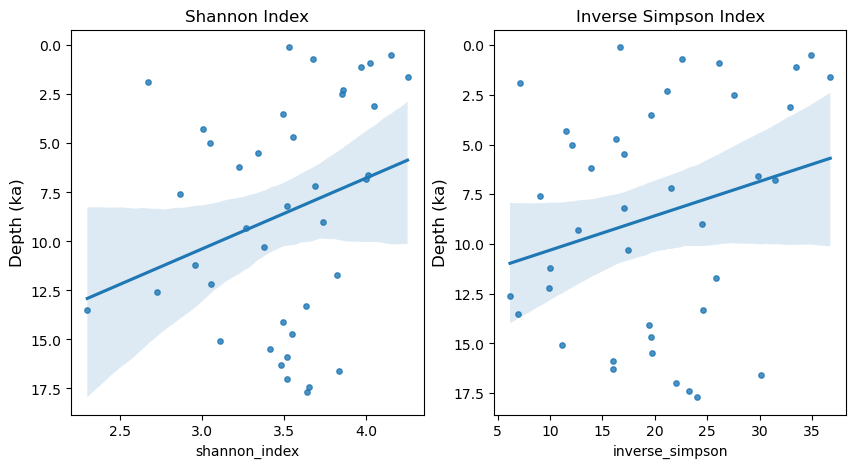

In [6]:
shannon_div = {"Sample":[], "shannon_index":[]}
inverse_simpson = {"Sample":[], "inverse_simpson":[]}
ages = df_contig_taxa['Sample'].unique()

df_rarefy = pd.read_csv('/Net/Groups/pbtdata/01_RAG/09_sediments/tibetan_sediments/04-analysis/rarefied_data_R.csv',index_col=0,header=0)

df_rarefy.index = df_rarefy.index.astype(float)

for a in ages:
    df = df_rarefy.loc[a]

    shannon_div['Sample'] = shannon_div["Sample"] + [a]
    index = shannon_index(df)
    shannon_div['shannon_index'] = shannon_div["shannon_index"] + [index]

    inverse_simpson['Sample'] = inverse_simpson["Sample"] + [a]
    inverse_simpson["inverse_simpson"] = inverse_simpson["inverse_simpson"] + [inv_simpsons(df)]

df_shannon_div_contigs = pd.DataFrame(shannon_div)
df_inverse_simpson_contigs = pd.DataFrame(inverse_simpson)

df_shannon_div_contigs.sort_values('Sample', ascending=True, inplace=True)
df_inverse_simpson_contigs.sort_values('Sample', ascending=True, inplace=True)


fig, axes = plt.subplots(1,2,figsize=(10,5))

sns.regplot(data=df_shannon_div_contigs,y='Sample', x='shannon_index', ax=axes[0], scatter=True, scatter_kws={'s':15})
axes[0].set_ylabel('Depth (ka)', fontsize=12)
axes[0].invert_yaxis()
axes[0].set_title('Shannon Index')

sns.regplot(data=df_inverse_simpson_contigs,y='Sample', x='inverse_simpson', ax=axes[1], scatter=True, scatter_kws={'s':15})
axes[1].set_title('Inverse Simpson Index')
axes[1].invert_yaxis()
axes[1].set_ylabel('Depth (ka)', fontsize=12)

In [7]:
def gamma_alpha_bac_plot(df,level,l,plot=True):
    if plot:
        fig, axes = plt.subplots(2,1,figsize=(10,5))

    total_bins = df.groupby('Sample')[level].sum().reset_index()

    pivot_df = pd.pivot_table(df,index='class', columns='Sample', values=level, aggfunc='sum', fill_value=0).reset_index()

    df_gamma = pivot_df.where(pivot_df['class'] == 'Gammaproteobacteria').dropna().set_index('class')
    df_gamma_transposed = df_gamma.T.reset_index()
    df_gamma_merged = df_gamma_transposed.merge(total_bins, on='Sample', suffixes=('','_total'))
    df_gamma_merged['Prob'] = (df_gamma_merged['Gammaproteobacteria'] / df_gamma_merged[level])*100

    if plot:
        axes[0].plot(df_gamma_merged['Sample'],df_gamma_merged['Prob'], color='green')
        axes[0].invert_xaxis()
        axes[0].set_title('Gammaprotebacteria')
        axes[0].set_xlabel('Depth (ka)')
        axes[0].set_ylabel(f'% of {l}')
        axes[0].fill_between(df_gamma_merged['Sample'], df_gamma_merged['Prob'], color='lightgreen', alpha=0.4)

    df_alpha = pivot_df.where(pivot_df['class'] == 'Alphaproteobacteria').dropna().set_index('class')
    df_alpha_transposed = df_alpha.T.reset_index()
    df_alpha_merged = df_alpha_transposed.merge(total_bins, on='Sample', suffixes=('','_total'))
    df_alpha_merged['Prob'] = (df_alpha_merged['Alphaproteobacteria'] / df_alpha_merged[level])*100

    if plot:
        axes[1].plot(df_alpha_merged['Sample'],df_alpha_merged['Prob'])
        axes[1].invert_xaxis()
        axes[1].set_title('Alphaproteobacteria')
        axes[1].set_xlabel('Depth (ka)')
        axes[1].set_ylabel(f'% of {l}')
        axes[1].fill_between(df_alpha_merged['Sample'], df_alpha_merged['Prob'], color='lightblue', alpha=0.4)
        plt.tight_layout()
    else:
        return df_alpha_merged, df_gamma_merged

plot with prevalence of gamma and alphaproteobacteria across core

/home/mkaiser/miniconda3/envs/statistics/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


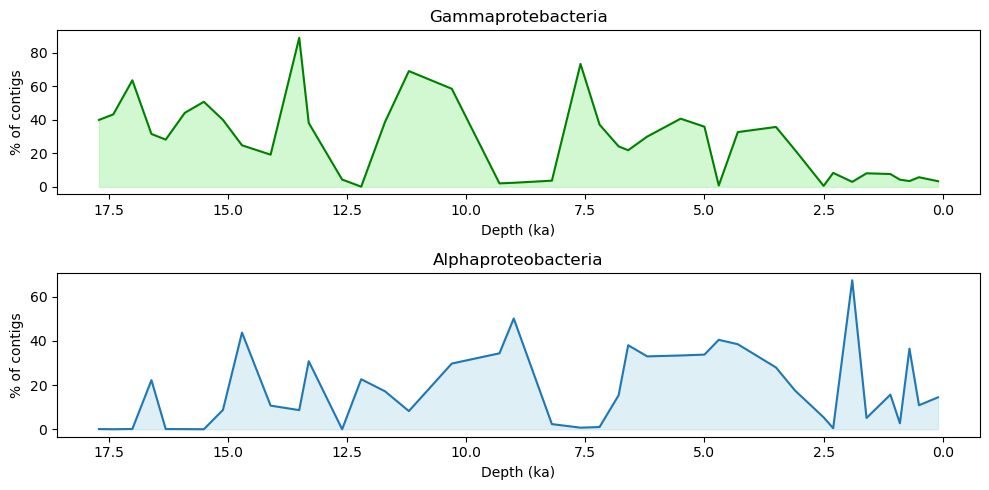

In [8]:
df_contig_taxa_length_corr['#contigs'] = 1
df = df_contig_taxa_length_corr[['Sample', 'class','#contigs']]
gamma_alpha_bac_plot(df,'#contigs','contigs')

/home/mkaiser/miniconda3/envs/statistics/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


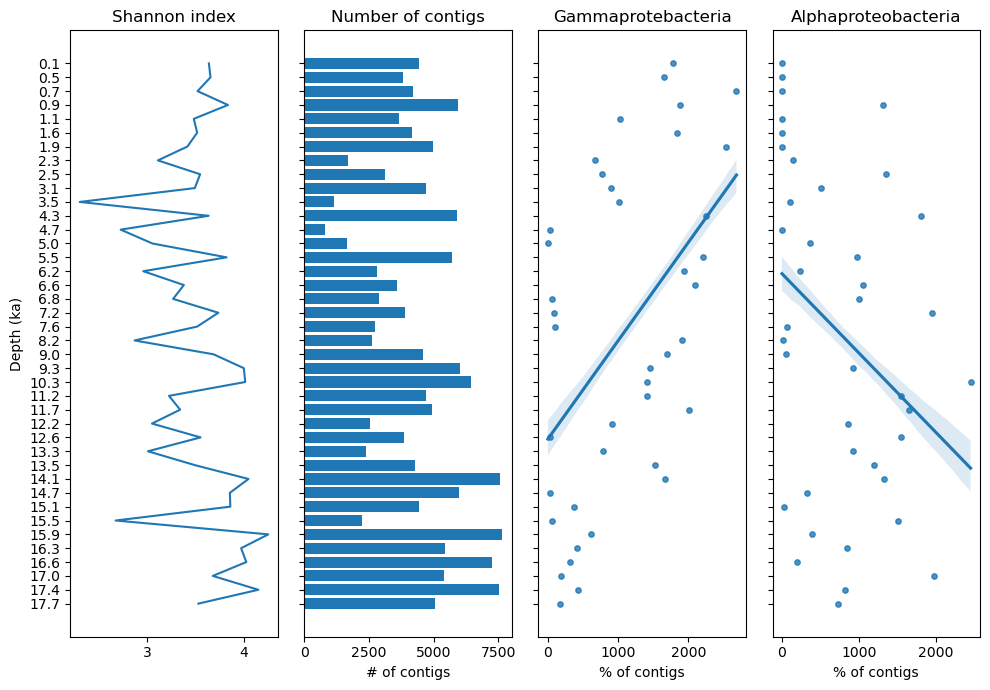

In [9]:
from matplotlib.ticker import MaxNLocator
fig, axes = plt.subplots(1,4,figsize=(10,7),sharey=True)

number_contigs = df_contig_taxa_length_corr[['Sample','#contigs']]
number_contigs = number_contigs.groupby('Sample').sum()
df = df_contig_taxa_length_corr[['Sample', 'class','#contigs']]
tmp = gamma_alpha_bac_plot(df,'#contigs','contigs',plot=False)
df_alpha_merged = tmp[0]
df_gamma_merged = tmp[1]

df_merged = df_shannon_div_contigs.merge(number_contigs, on='Sample')
df_merged = df_merged.merge(df_alpha_merged, on='Sample')
df_merged = df_merged.merge(df_gamma_merged, on='Sample')

df_merged['y'] = np.arange(len(df_merged))
category_reversed = df_merged['Sample'][::-1]

########################
#Shannon_index
########################

axes[0].plot(df_merged['shannon_index'], df_merged['y'])
axes[0].set_title('Shannon index')
axes[0].set_ylabel('Depth (ka)')
axes[0].set_xlabel('')
axes[0].set_yticks(df_merged['y'])
axes[0].yaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))
axes[0].set_yticklabels(category_reversed)

########################
#Number of mags
########################

axes[1].barh(df_merged['y'], df_merged['#contigs'])
axes[1].set_title('Number of contigs')
axes[1].set_ylabel('')
axes[1].set_xlabel('# of contigs')
axes[1].set_yticks(df_merged['y'])
axes[1].set_yticklabels(category_reversed)

########################
#Gammaproteobacteria
########################
sns.regplot(data=df_merged,y='y', x='Gammaproteobacteria', ax=axes[2],ci=35, scatter=True, scatter_kws={'s':15})
axes[2].set_title('Gammaprotebacteria')
axes[2].set_ylabel('')
axes[2].set_xlabel('% of contigs')
axes[2].set_yticks(df_merged['y'])
axes[2].set_yticklabels(category_reversed)

########################
#Alphaproteobacteria
########################
sns.regplot(data=df_merged,y='y', x='Alphaproteobacteria', ax=axes[3], ci=35, scatter=True, scatter_kws={'s':15})
axes[3].set_title('Alphaproteobacteria')
axes[3].set_ylabel('')
axes[3].set_xlabel('% of contigs')
axes[3].set_yticks(df_merged['y'])
axes[3].set_yticklabels(category_reversed)

plt.tight_layout()

nmds, pca plot with contigs based on bray-curtis

/home/mkaiser/miniconda3/envs/statistics/lib/python3.7/site-packages/pandas/core/frame.py:6402: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  key,
/home/mkaiser/miniconda3/envs/statistics/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.


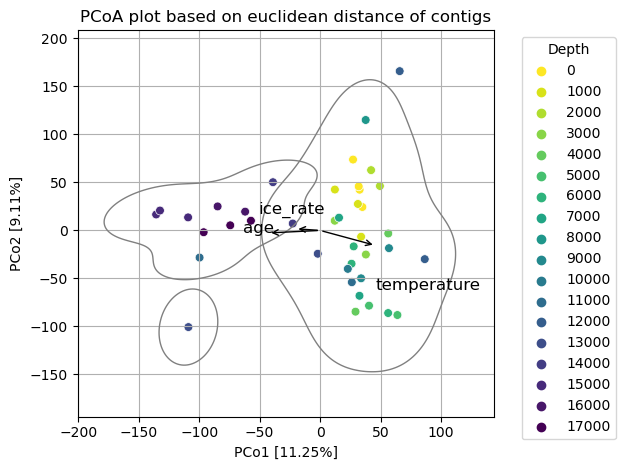

In [10]:
#['euclidean', 'l2', 'l1', 'manhattan', 'cityblock', 'braycurtis', 'canberra', 'chebyshev', 'correlation', 'cosine', 'dice', 'hamming', 'jaccard',
#  'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean',
#  'yule', 'wminkowski', 'nan_euclidean', 'haversine']


n_colors= 18
viridis = get_cmap('viridis_r')
palette = sns.color_palette(viridis(np.linspace(0, 1, n_colors)))

result = beta_diversity(metric='euclidean', counts=df_rarefy, ids=df_rarefy.index, validate=True)

df_distance = pd.DataFrame(result.data, index=result.ids, columns=result.ids)

ordination_results = pcoa(distance_matrix=result, number_of_dimensions=8)
ordination_results.proportion_explained

coords = ordination_results.samples
coords_array = coords.values
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(coords_array)

stress = {}
for a in ages:
    stress[a] = int(a) * 1000

coords['Stress'] = coords.index.map(stress)
coords.sort_values('Stress', inplace=True)
coords['Stress'] = coords['Stress'].astype(str)

env = pd.read_csv('/Net/Groups/pbtdata/01_RAG/09_sediments/tibetan_sediments/03-data/03-Supplementary-Data3-MutipleData_edited_down.csv', index_col=False)

env_data = env[['age','temperature','ice_rate','depth']]
env_data.set_index('depth', inplace=True)
env_data.sort_index(ascending=True, inplace=True)

scaler_env = StandardScaler()
env_scaled = scaler_env.fit_transform(env_data)

# Convert to DataFrame
env_scaled_df = pd.DataFrame(env_scaled, columns=env_data.columns)

# Add vectors for environmental factors
env_loadings = np.dot(env_scaled_df.T, coords[['PC1','PC2']]) / len(env_scaled_df) 

for i, env_factor in enumerate(env_scaled_df.columns):
    plt.annotate('', xy=(0, 0), xytext=(env_loadings[i, 0], env_loadings[i, 1]), arrowprops=dict(arrowstyle="<-"))
    if env_factor == 'age':
        plt.text(env_loadings[i, 0]*1.5, env_loadings[i, 1]*1.0, env_factor, color='black', fontsize=12)
    if env_factor == 'ice_rate':
        plt.text(env_loadings[i, 0]*2.5, env_loadings[i, 1]*10.0, env_factor, color='black', fontsize=12)
    if env_factor == 'temperature':
        plt.text(env_loadings[i, 0]*1.0, env_loadings[i, 1]*4.0, env_factor, color='black', fontsize=12)

sns.scatterplot(data=coords, x='PC1', y='PC2', hue='Stress', s=40,palette=palette)

for cluster_label in np.unique(clusters):
    sns.kdeplot(x=coords_array[clusters == cluster_label, 0], y=coords_array[clusters == cluster_label, 1], 
                levels=1, linewidths=1, color="grey")
    
plt.title('PCoA plot based on euclidean distance of contigs')
plt.xlabel(f'PCo1 [{round((ordination_results.proportion_explained[0] * 100),2)}%]')
plt.ylabel(f'PCo2 [{round((ordination_results.proportion_explained[1] * 100),2)}%]')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left', title='Depth')

plt.tight_layout()
plt.show()

/home/mkaiser/miniconda3/envs/statistics/lib/python3.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.005349219375490177 and the largest is 2.0287510532667556.
  RuntimeWarning
/home/mkaiser/miniconda3/envs/statistics/lib/python3.7/site-packages/pandas/core/frame.py:6402: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  key,


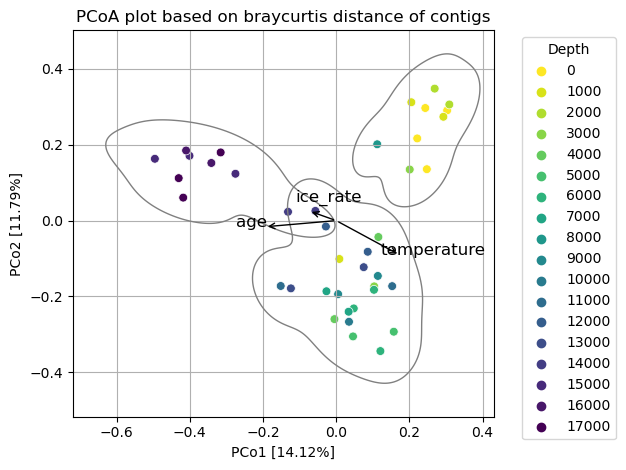

In [13]:
#['euclidean', 'l2', 'l1', 'manhattan', 'cityblock', 'braycurtis', 'canberra', 'chebyshev', 'correlation', 'cosine', 'dice', 'hamming', 'jaccard',
#  'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean',
#  'yule', 'wminkowski', 'nan_euclidean', 'haversine']

n_colors= 18
viridis = get_cmap('viridis_r')
palette = sns.color_palette(viridis(np.linspace(0, 1, n_colors)))

bray_result = beta_diversity(metric='braycurtis', counts=df_rarefy, ids=df_rarefy.index, validate=True)


df_distance = pd.DataFrame(bray_result.data, index=bray_result.ids, columns=bray_result.ids)

ordination_results = pcoa(distance_matrix=bray_result, number_of_dimensions=8)
ordination_results.proportion_explained

coords = ordination_results.samples
coords_array = coords.values
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(coords_array)
stress = {}

for a in ages:
    stress[a] = int(a) * 1000

coords['Stress'] = coords.index.map(stress)
coords.sort_values('Stress', inplace=True)
coords['Stress'] = coords['Stress'].astype(str)

env = pd.read_csv('/Net/Groups/pbtdata/01_RAG/09_sediments/tibetan_sediments/03-data/03-Supplementary-Data3-MutipleData_edited_down.csv', index_col=False)

env_data = env[['age','temperature','ice_rate','depth']]
env_data.set_index('depth', inplace=True)
env_data.sort_index(ascending=True, inplace=True)

scaler_env = StandardScaler()
env_scaled = scaler_env.fit_transform(env_data)

# Convert to DataFrame
env_scaled_df = pd.DataFrame(env_scaled, columns=env_data.columns)

# Add vectors for environmental factors
env_loadings = np.dot(env_scaled_df.T, coords[['PC1','PC2']]) / len(env_scaled_df)  # Compute environmental factor loadings

for i, env_factor in enumerate(env_scaled_df.columns):
    plt.annotate('', xy=(0, 0), xytext=(env_loadings[i, 0], env_loadings[i, 1]), arrowprops=dict(arrowstyle="<-"))
    if env_factor == 'age':
        plt.text(env_loadings[i, 0]*1.4, env_loadings[i, 1]*1.0, env_factor, color='black', fontsize=12)
    if env_factor == 'ice_rate':
        plt.text(env_loadings[i, 0]*1.5, env_loadings[i, 1]*2.0, env_factor, color='black', fontsize=12)
    if env_factor == 'temperature':
        plt.text(env_loadings[i, 0]*0.7, env_loadings[i, 1]*1.0, env_factor, color='black', fontsize=12)

sns.scatterplot(data=coords, x='PC1', y='PC2', hue='Stress', s=40,palette=palette)

for cluster_label in np.unique(clusters):
    sns.kdeplot(x=coords_array[clusters == cluster_label, 0], y=coords_array[clusters == cluster_label, 1], 
                levels=1, linewidths=1, color="grey")

plt.title('PCoA plot based on braycurtis distance of contigs')
plt.xlabel(f'PCo1 [{round((ordination_results.proportion_explained[0] * 100),2)}%]')
plt.ylabel(f'PCo2 [{round((ordination_results.proportion_explained[1] * 100),2)}%]')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left', title='Depth')

plt.tight_layout()
plt.show()

In [12]:
from skbio.stats.distance import permanova
signi_tmp = permanova(bray_result, grouping=env_data, column='temperature',permutations=5000)
print('bray-curtis temperature:')
print('p-value:',signi_tmp['p-value'])
# signi_age = permanova(bray_result, grouping=env_data, column='age')
# print(signi_age)
signi_ice = permanova(bray_result, grouping=env_data, column='ice_rate',permutations=5000)
print('bray-curtis ice_rate:')
print('p-value:',signi_ice['p-value'])
signi_tmp = permanova(result, grouping=env_data, column='temperature',permutations=5000)
print('euclidean temperature:')
print('p-value:',signi_tmp['p-value'])
# signi_age = permanova(bray_result, grouping=env_data, column='age')
# print(signi_age)
signi_ice = permanova(result, grouping=env_data, column='ice_rate',permutations=5000)
print('euclidean ice_rate:')
print('p-value:',signi_ice['p-value'])

bray-curtis temperature:
p-value: 0.1219756048790242
bray-curtis ice_rate:
p-value: 0.0007998400319936012
euclidean temperature:
p-value: 0.23375324935012998
euclidean ice_rate:
p-value: 0.26814637072585484
